In [13]:
# Data Manipulation and Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning and Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
from imblearn.over_sampling import SMOTE
from category_encoders import TargetEncoder
import category_encoders as ce

# Model Saving and Loading
import pickle

Dataset loaded successfully!

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      50000 non-null  object
 1   timestamp    50000 non-null  object
 2   repository   50000 non-null  object
 3   commit_id    50000 non-null  object
 4   file_path    50000 non-null  object
 5   mode         50000 non-null  int64 
 6   id           50000 non-null  object
 7   ref          50000 non-null  object
 8   language     50000 non-null  object
 9   access_hour  50000 non-null  int64 
dtypes: int64(2), object(8)
memory usage: 3.8+ MB

Missing Values:
user_id        0
timestamp      0
repository     0
commit_id      0
file_path      0
mode           0
id             0
ref            0
language       0
access_hour    0
dtype: int64

Sample Data:
               user_id                timestamp      repository  \
0  Christopher Chedeau  

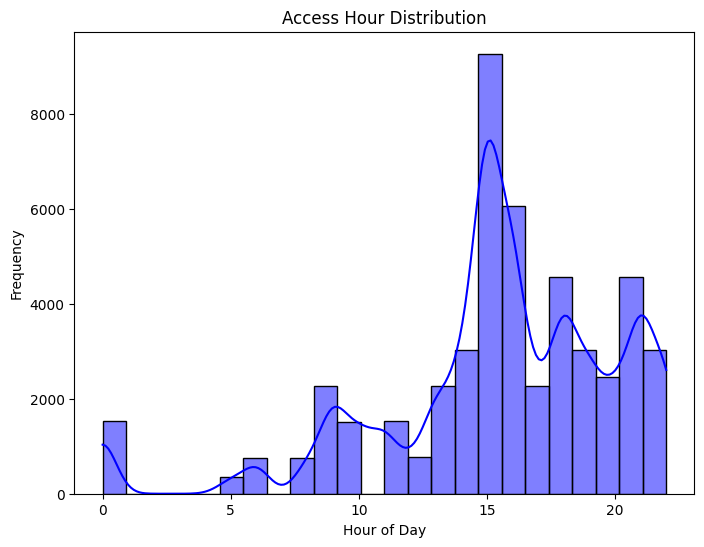

In [14]:
# Load the dataset
def load_data(file_path):
    try:
        data = pd.read_csv(file_path)
        print("Dataset loaded successfully!")
        return data
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return None

# Explore the dataset
def explore_data(data):
    print("\nDataset Info:")
    data.info()

    print("\nMissing Values:")
    print(data.isnull().sum())

    print("\nSample Data:")
    print(data.head())

    # Visualize access hours
    plt.figure(figsize=(8, 6))
    sns.histplot(data['access_hour'], bins=24, kde=True, color="blue")
    plt.title('Access Hour Distribution')
    plt.xlabel('Hour of Day')
    plt.ylabel('Frequency')
    plt.show()

# Load and explore
file_path = "UnauthorizedAccess.csv"  # Replace with your dataset path
data = load_data(file_path)
if data is not None:
    explore_data(data)


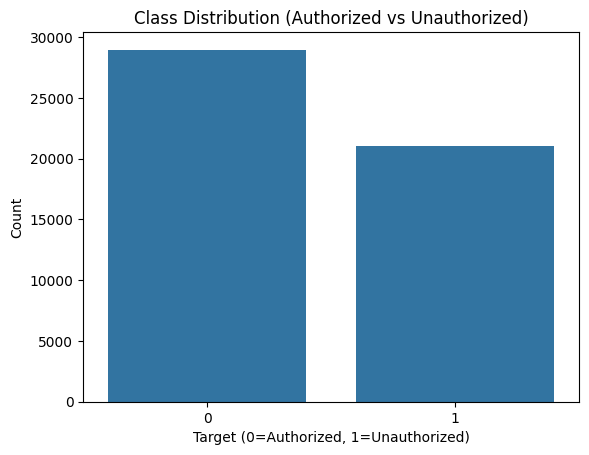

In [15]:
# Define a function to classify access as authorized (0) or unauthorized (1)
def classify_access(row):
    # Example logic:
    # Unauthorized if mode is 777
    if row['mode'] == 777:
        return 1
    # Unauthorized if access hour is outside 9 AM to 5 PM
    elif row['access_hour'] < 9 or row['access_hour'] > 17:
        return 1
    # Otherwise, authorized
    else:
        return 0

# Apply the function to create the target column
data['target'] = data.apply(classify_access, axis=1)

# Visualize class distribution
sns.countplot(x='target', data=data)
plt.title('Class Distribution (Authorized vs Unauthorized)')
plt.xlabel('Target (0=Authorized, 1=Unauthorized)')
plt.ylabel('Count')
plt.show()


In [16]:
# Check for duplicates
num_duplicates = data.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")

# Remove duplicates
data = data.drop_duplicates()

# Check the size of the dataset after removing duplicates
print(f"Dataset size after removing duplicates: {data.shape}")


Number of duplicate rows: 0
Dataset size after removing duplicates: (50000, 11)


In [17]:
# Check unique values in each column
print(data.nunique())

# Display the first few rows
print(data.head(10))

# Check the distribution of the `target` column
print(data['target'].value_counts())


user_id         22
timestamp       77
repository       4
commit_id       78
file_path      962
mode             2
id             962
ref              1
language         4
access_hour     18
target           2
dtype: int64
               user_id                timestamp      repository  \
0  Christopher Chedeau  2016-06-16 15:33:32 UTC  facebook/react   
1  Christopher Chedeau  2016-06-16 15:33:32 UTC  facebook/react   
2  Christopher Chedeau  2016-06-16 15:33:32 UTC  facebook/react   
3  Christopher Chedeau  2016-06-16 15:33:32 UTC  facebook/react   
4  Christopher Chedeau  2016-06-16 15:33:32 UTC  facebook/react   
5  Christopher Chedeau  2016-06-16 15:33:32 UTC  facebook/react   
6  Christopher Chedeau  2016-06-16 15:33:32 UTC  facebook/react   
7  Christopher Chedeau  2016-06-16 15:33:32 UTC  facebook/react   
8  Christopher Chedeau  2016-06-16 15:33:32 UTC  facebook/react   
9  Christopher Chedeau  2016-06-16 15:33:32 UTC  facebook/react   

                                  commit

In [ ]:
# Preprocessing function
def preprocess_data(data):
    # Step 1: Convert `timestamp` to datetime format
    data['timestamp'] = pd.to_datetime(data['timestamp'], errors='coerce')

    # Step 2: Extract useful features from `timestamp`
    data['hour'] = data['timestamp'].dt.hour               # Hour of the day
    data['day'] = data['timestamp'].dt.day                 # Day of the month
    data['month'] = data['timestamp'].dt.month             # Month of the year
    data['year'] = data['timestamp'].dt.year               # Year
    data['day_of_week'] = data['timestamp'].dt.dayofweek   # Day of the week (0=Monday, 6=Sunday)

    data['language'] = data['language'].fillna('Unknown')  # Replace NaN or missing values with 'Unknown'
    data['repository'] = data['repository'].fillna('Unknown')  # Replace NaN or missing values with 'Unknown'
    
    # Step 3: Handle missing values by filling them with 'Unknown'
    data['language'] = data['language'].fillna('Unknown')  # Replace NaN or missing values with 'Unknown'
    data['repository'] = data['repository'].fillna('Unknown')  # Replace NaN or missing values with 'Unknown'

    # Step 4: Apply Target Encoding on `language` and `repository`
    encoder = ce.TargetEncoder(cols=['language', 'repository'])
    data[['language', 'repository']] = encoder.fit_transform(data[['language', 'repository']], data['target'])

    # Save the encoder for later use
    with open("target_encoder.pkl", "wb") as f:
        pickle.dump(encoder, f)

    '''# Step 3: Encode categorical variables
    label_encoder_language = LabelEncoder()
    label_encoder_repository = LabelEncoder()

    # Fit encoders on training data
    data['language'] = label_encoder_language.fit_transform(data['language'])
    data['repository'] = label_encoder_repository.fit_transform(data['repository'])

    # Add missing categories to LabelEncoder in the training script
    all_languages = ['Python', 'Java', 'C++', 'Ruby', 'JavaScript','Go', 'Rust', 'Unknown']
    all_repositories = ['repository1', 'repository2', 'restricted_repo1', 'restricted_repo2', 'Unknown']

    # Update encoder classes
    label_encoder_language.classes_ = np.array(sorted(set(list(label_encoder_language.classes_) + all_languages)))
    label_encoder_repository.classes_ = np.array(sorted(set(list(label_encoder_repository.classes_) + all_repositories)))'''

    # Step 4: Drop unnecessary columns
    columns_to_drop = ['user_id', 'commit_id', 'file_path', 'ref', 'id', 'timestamp']
    X = data.drop(columns=columns_to_drop + ['target'])  # Drop target column temporarily
    y = data['target']  # Target column remains as-is

    # Step 5: Scale numerical features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Save the scaler
    with open("scaler.pkl", "wb") as f:
        pickle.dump(scaler, f)

    return X_scaled, y, encoder, scaler



In [19]:
# Preprocess the data
X, y, encoder, scaler= preprocess_data(data)

# Check the first few rows of the preprocessed data
print("Preprocessed Features (X):", X[:5])  # First 5 rows
print("Target (y):", y[:5])  # First 5 target values

# Check the shapes of the features and target arrays
print("\nShape of Features (X):", X.shape)
print("Shape of Target (y):", y.shape)

# Ensure that no NaN or missing values exist in the preprocessed features
print("\nAre there any missing values in X?", np.isnan(X).any())
print("Are there any missing values in y?", pd.isnull(y).any())


['repository', 'mode', 'language', 'access_hour', 'hour', 'day', 'month', 'year', 'day_of_week']
Preprocessed Features (X): [[ 7.37771737 -0.03607897  7.37771737 -0.09135111 -0.09135111  0.30622276
   0.16871408  0.55853127  0.67189702]
 [ 7.37771737 -0.03607897  7.37771737 -0.09135111 -0.09135111  0.30622276
   0.16871408  0.55853127  0.67189702]
 [ 7.37771737 -0.03607897  7.37771737 -0.09135111 -0.09135111  0.30622276
   0.16871408  0.55853127  0.67189702]
 [ 7.37771737 -0.03607897  7.37771737 -0.09135111 -0.09135111  0.30622276
   0.16871408  0.55853127  0.67189702]
 [ 7.37771737 -0.03607897  7.37771737 -0.09135111 -0.09135111  0.30622276
   0.16871408  0.55853127  0.67189702]]
Target (y): 0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64

Shape of Features (X): (50000, 9)
Shape of Target (y): (50000,)

Are there any missing values in X? False
Are there any missing values in y? False


['access_hour', 'hour', 'day_of_week', 'language', 'month', 'mode', 'day', 'repository', 'year', 'repository_risk', 'unusual_hour', 'mode_category']
Target Distribution in Training Data:
target
0    23140
1    16860
Name: count, dtype: int64

Starting Grid Search for Random Forest Hyperparameter Tuning...
Best Hyperparameters: {'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Cross-Validation Accuracy: 1.0000


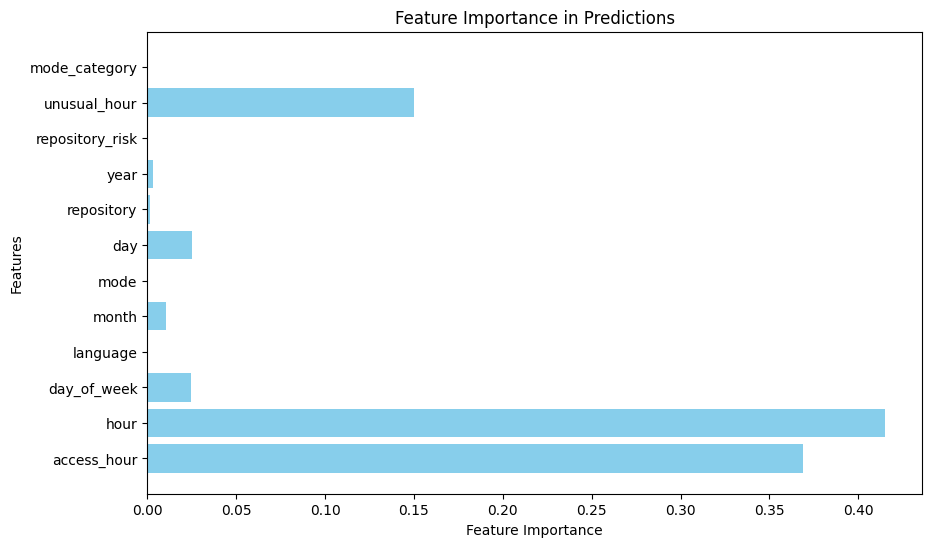


Model Evaluation:
Confusion Matrix:
[[5835    0]
 [   0 4165]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5835
           1       1.00      1.00      1.00      4165

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000

Accuracy Score: 1.0

Cross-Validation Accuracy: 0.9849
Model saved as 'trained_model.pkl'
Feature names saved as 'feature_names.pkl'
Label encoder saved as 'label_encoder_language.pkl'
Label encoder saved as 'label_encoder_repository.pkl'


In [22]:

# Function to train and evaluate the model
def train_model(X, y):

    # Feature Engineering
    # Add repository risk levels (e.g., flag restricted repositories)
    data['repository_risk'] = data['repository'].apply(lambda x: 1 if x in ['restricted_repo1', 'restricted_repo2'] else 0)

    # Flag unusual access hours (e.g., outside 6 AM to 6 PM)
    data['unusual_hour'] = data['hour'].apply(lambda x: 1 if x < 6 or x > 18 else 0)

    # Group mode into restricted and unrestricted categories
    data['mode_category'] = data['mode'].apply(lambda x: 1 if x == 777 else 0)

    # Update feature set to include new engineered features
    engineered_features = ['repository_risk', 'unusual_hour', 'mode_category']
    X = data[['access_hour', 'hour', 'day_of_week', 'language', 'month', 'mode', 'day', 'repository', 'year'] + engineered_features]

    print(X.columns.tolist())
    # Feature names corresponding to X
    feature_names = X.columns

    # Step 1: Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

    # Check the target distribution in the training data
    y_train_series = pd.Series(y_train)
    print("Target Distribution in Training Data:")
    print(y_train_series.value_counts())

    # Step 2: Apply SMOTE to handle class imbalance
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    # Step 3: Define hyperparameter grid for Random Forest
    param_grid = {
        'n_estimators': [100, 150],   # Number of trees
        'max_depth': [10, None],      # Maximum depth of trees
        'min_samples_split': [2, 5],  # Minimum samples to split an internal node
        'min_samples_leaf': [1, 2],    # Minimum samples in a leaf node
        'max_features': ['sqrt'], # Number of features to consider at each split
        'class_weight': ['balanced']  # Handle class imbalance
    }

    # Step 4: Perform grid search
    print("\nStarting Grid Search for Random Forest Hyperparameter Tuning...")
    grid_search = GridSearchCV(
        RandomForestClassifier(random_state=42),
        param_grid,
        scoring='accuracy',
        cv=5,  # 5-fold cross-validation
        n_jobs=-1  # Utilize all available cores
    )
    grid_search.fit(X_train, y_train)

    # Step 5: Best model and hyperparameters
    model = grid_search.best_estimator_
    print(f"Best Hyperparameters: {grid_search.best_params_}")
    print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")

    # Analyze feature importance
    importances = model.feature_importances_
    plt.figure(figsize=(10, 6))
    plt.barh(feature_names, importances, color='skyblue')
    plt.xlabel("Feature Importance")
    plt.ylabel("Features")
    plt.title("Feature Importance in Predictions")
    plt.show()

    # Evaluate the model on the test set
    y_pred = model.predict(X_test)
    print("\nModel Evaluation:")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy Score: {accuracy_score(y_test, y_pred)}")

    # Perform Cross-Validation
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    print(f"\nCross-Validation Accuracy: {cv_scores.mean():.4f}")

    return model, feature_names

# Function to save the trained model
def save_model(model, file_name):
    with open(file_name, 'wb') as f:
        pickle.dump(model, f)
    print(f"Model saved as '{file_name}'")

def save_feature_names(feature_names, file_name):
    with open(file_name, 'wb') as f:
        pickle.dump(feature_names, f)
    print(f"Feature names saved as '{file_name}'")

# Function to save LabelEncoders
def save_label_encoder(encoder, file_name):
    with open(file_name, 'wb') as f:
        pickle.dump(encoder, f)
    print(f"Label encoder saved as '{file_name}'")


# Main Script for Training
if __name__ == "__main__":
    # Assuming X and y are already preprocessed
    # Example: X, y = preprocess_data(data)

    # Step 1: Train the model
    model,feature_names  = train_model(X, y)

    # Step 2: Save the trained model
    save_model(model, 'trained_model.pkl')

    # Save feature names
    save_feature_names(feature_names, 'feature_names.pkl')

    label_encoder_language = LabelEncoder()
    label_encoder_repository = LabelEncoder()

    # Fit the encoders (replace 'data' with your actual DataFrame)
    data['language'] = label_encoder_language.fit_transform(data['language'])
    data['repository'] = label_encoder_repository.fit_transform(data['repository'])

    # Save the encoders
    save_label_encoder(label_encoder_language, "label_encoder_language.pkl")
    save_label_encoder(label_encoder_repository, "label_encoder_repository.pkl")


In [21]:
data.head(50)

,user_id,timestamp,repository,commit_id,file_path,mode,id,ref,language,access_hour,target,hour,day,month,year,day_of_week,repository_risk,unusual_hour,mode_category
0,Christopher Chedeau,2016-06-16 15:33:32+00:00,1,1c71970431410d2ea39f049341b0b5d4be529e86,docs/_layouts/redirect.html,33188,64af3722a3041666a32dc62a7b1b8dcdba5e04c1,refs/heads/master,1,15,0,15,16,6,2016,3,0,0,0
1,Christopher Chedeau,2016-06-16 15:33:32+00:00,1,1c71970431410d2ea39f049341b0b5d4be529e86,docs/css/react.scss,33188,29840dbf25f2b7e094a1a0776dcd7bcf3405bd7e,refs/heads/master,1,15,0,15,16,6,2016,3,0,0,0
2,Christopher Chedeau,2016-06-16 15:33:32+00:00,1,1c71970431410d2ea39f049341b0b5d4be529e86,docs/img/blog/markdown_refactor.png,33188,8d56be161b21e10423ff1a77170ff23f9198bf74,refs/heads/master,1,15,0,15,16,6,2016,3,0,0,0
3,Christopher Chedeau,2016-06-16 15:33:32+00:00,1,1c71970431410d2ea39f049341b0b5d4be529e86,src/renderers/native/ReactNativeMount.js,33188,d9fe2f28623fe3b381b8f6f8efd6c6f378e89917,refs/heads/master,1,15,0,15,16,6,2016,3,0,0,0
4,Christopher Chedeau,2016-06-16 15:33:32+00:00,1,1c71970431410d2ea39f049341b0b5d4be529e86,src/renderers/shared/fiber/__tests__/ReactCoro...,33188,cd5423625894a7de2b7b6ba64331602555bfd261,refs/heads/master,1,15,0,15,16,6,2016,3,0,0,0
5,Christopher Chedeau,2016-06-16 15:33:32+00:00,1,1c71970431410d2ea39f049341b0b5d4be529e86,src/renderers/native/__mocks__/deepDiffer.js,33188,cc58e4b328e54a45ff924674dea0325ce14005bb,refs/heads/master,1,15,0,15,16,6,2016,3,0,0,0
6,Christopher Chedeau,2016-06-16 15:33:32+00:00,1,1c71970431410d2ea39f049341b0b5d4be529e86,src/renderers/dom/client/ReactDOMTreeTraversal.js,33188,9cbc39f3a2a447e86b2072a8e33f8392bb5f440f,refs/heads/master,1,15,0,15,16,6,2016,3,0,0,0
7,Christopher Chedeau,2016-06-16 15:33:32+00:00,1,1c71970431410d2ea39f049341b0b5d4be529e86,docs/_posts/2015-09-02-new-react-developer-too...,33188,8f1ec03e4f739dc7bb5a5fd7bb2069f38a7aa04f,refs/heads/master,1,15,0,15,16,6,2016,3,0,0,0
8,Christopher Chedeau,2016-06-16 15:33:32+00:00,1,1c71970431410d2ea39f049341b0b5d4be529e86,docs/tips/14-communicate-between-components.md,33188,3038be7ccb35b4664584ff4fe739e2403c630fee,refs/heads/master,1,15,0,15,16,6,2016,3,0,0,0
9,Christopher Chedeau,2016-06-16 15:33:32+00:00,1,1c71970431410d2ea39f049341b0b5d4be529e86,docs/img/blog/monkeys.gif,33188,3da6185ce6854443332503f4d007aa6aaa6fe81f,refs/heads/master,1,15,0,15,16,6,2016,3,0,0,0
